In [22]:
from nba_api.stats.endpoints import playbyplayv3
import pandas as pd
from nba_api.stats.endpoints import leaguegamelog
import numpy as np
import scipy 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time 
import os 

In [23]:
def classify_shot_from_text(row):
    state = row.lower()
    
    if 'made shot' in state:
        result = 'Made'
    elif 'missed shot' in state:
        result = 'Missed'
    else:
        return None  # Not a shot

    layup_keywords = ['layup', 'dunk', 'tip', 'putback', 'alley oop', 'finger roll', 'hook shot']
    midrange_keywords = ['jump shot', 'pullup', 'fadeaway', 'turnaround', 'step back', 'floating']

    if any(kw in state for kw in layup_keywords):
        shot_type = 'Layup'
    elif any(kw in state for kw in midrange_keywords):
        shot_type = 'Midrange'
    else:
        shot_type = 'Three'

    return f"{result} {shot_type}"

def get_game_transitions(game_id):
    """
    Fetch play-by-play data for a single game and extract (state, next_state) transitions.
    
    Parameters:
        game_id (str): The NBA game ID.
    
    Returns:
        pd.DataFrame: DataFrame containing 'state', 'next_state', and 'game_id'.
    """
    try:
        # Fetch play-by-play data
        log = playbyplayv3.PlayByPlayV3(game_id=game_id)
        gamelog = log.get_data_frames()[0]
        print(log.get_data_frames())
        # Build raw state column
        gamelog['state'] = gamelog['actionType'].fillna('') + ' - ' + gamelog['subType'].fillna('')

        # Drop Instant Replay rows early
        gamelog = gamelog[~gamelog['state'].str.contains('Instant Replay', na=False)].copy()

        # Classify shots using text analysis
        shot_mask = gamelog['state'].str.contains('Made Shot|Missed Shot', na=False)
        gamelog.loc[shot_mask, 'state'] = gamelog.loc[shot_mask, 'state'].apply(classify_shot_from_text)

        
        
        # Normalize other event types
        gamelog.loc[gamelog['state'].str.contains('Turnover', na=False), 'state'] = 'Turnover'
        gamelog.loc[gamelog['state'].str.contains('Foul', na=False), 'state'] = 'Foul'
        gamelog.loc[gamelog['state'].str.contains('Substitution', na=False), 'state'] = 'Substitution'
        gamelog.loc[gamelog['state'].str.contains('Free Throw', na=False), 'state'] = 'Free Throw'
        gamelog.loc[gamelog['state'].str.contains('Rebound', na=False), 'state'] = 'Rebound'
        gamelog.loc[gamelog['state'].str.contains('Timeout', na=False), 'state'] = 'Timeout'
        gamelog.loc[gamelog['state'].str.contains('Violation', na=False), 'state'] = 'Violation'
        gamelog.loc[gamelog['state'].str.contains('Jump Ball', na=False), 'state'] = 'Jump Ball'
        

        # Compute next state
        gamelog['next_state'] = gamelog['state'].shift(-1)

        # Drop rows where next_state is NaN, and make a safe copy
        transitions = gamelog.dropna(subset=['next_state']).copy()

        # Add game_id safely
        transitions['game_id'] = game_id

        # Return only relevant columns
        return transitions
    
    except Exception as e:
        print(f"[ERROR] Game ID {game_id} failed: {e}")
        return pd.DataFrame()  # return empty DataFrame on error
from nba_api.stats.endpoints import leaguegamelog

# Get all game IDs from the 2023–24 season
log = leaguegamelog.LeagueGameLog(season='2024-25', season_type_all_star='Regular Season')
game_ids = log.get_data_frames()[0]['GAME_ID'].unique()

# Collect all transitions
all_transitions = []

for gid in tqdm(game_ids[:1]):  # Use a smaller slice to avoid rate-limiting initially
    df = get_game_transitions(gid)
    if not df.empty:
        all_transitions.append(df)
    time.sleep(0.6)  # Be kind to the API

# Combine into one big DataFrame
df_all = pd.concat(all_transitions, ignore_index=True)
df_all = df_all[~((df_all['state'] == ' - ') | (df_all['next_state'] == ' - '))].copy()


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

[         gameId  actionNumber        clock  period      teamId teamTricode  \
0    0022400062             2  PT12M00.00S       1           0               
1    0022400062             4  PT12M00.00S       1  1610612747         LAL   
2    0022400062             7  PT11M32.00S       1  1610612750         MIN   
3    0022400062             8  PT11M29.00S       1  1610612747         LAL   
4    0022400062             9  PT11M18.00S       1  1610612747         LAL   
..          ...           ...          ...     ...         ...         ...   
494  0022400062           675  PT00M23.30S       4  1610612747         LAL   
495  0022400062           676  PT00M19.60S       4  1610612750         MIN   
496  0022400062           676  PT00M19.60S       4  1610612747         LAL   
497  0022400062           678  PT00M17.00S       4  1610612747         LAL   
498  0022400062           679  PT00M00.00S       4           0               

     personId playerName   playerNameI  xLegacy  ...  scoreHom

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


In [24]:
states = list(set(list(df_all['state'])))

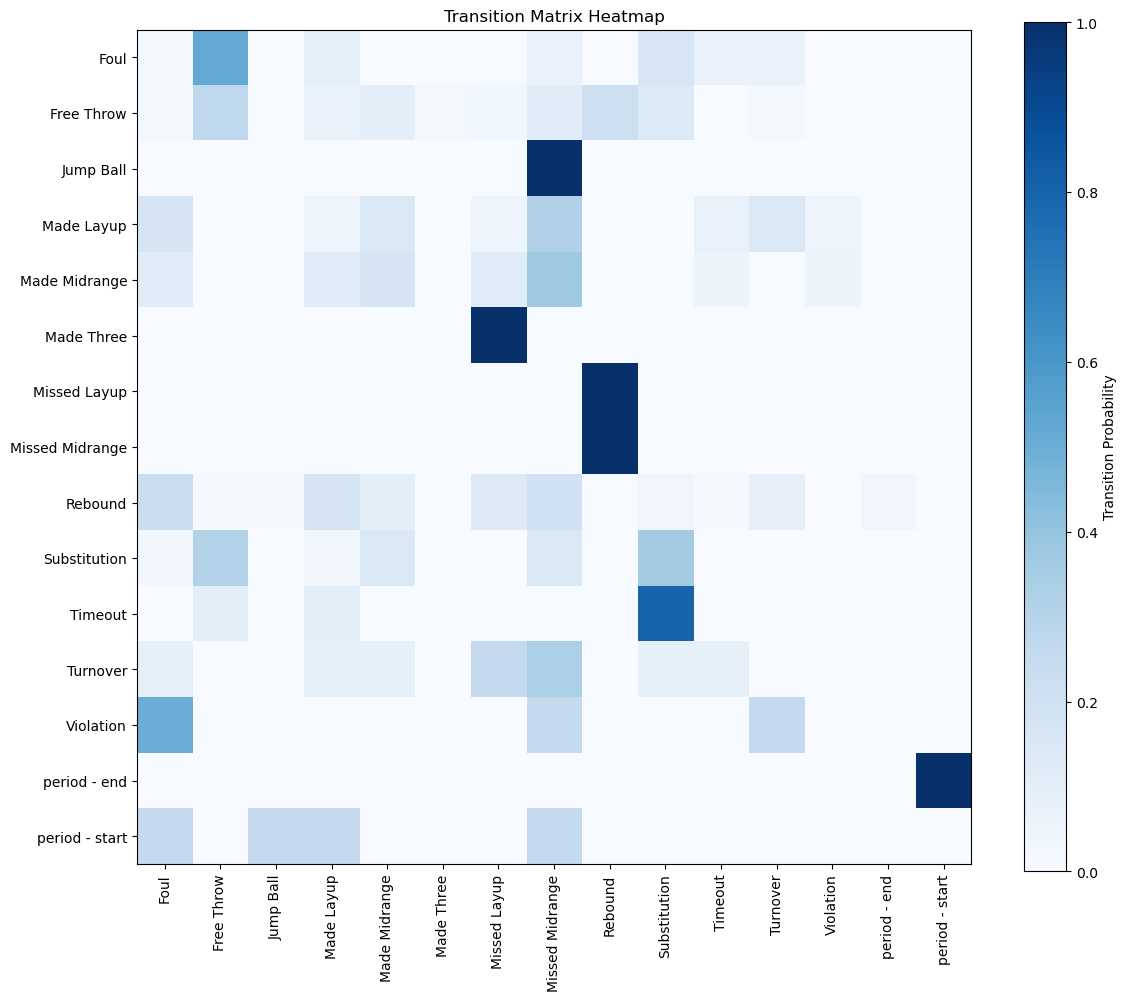

In [25]:
# Count transitions between states
transition_counts = df_all.groupby(['state', 'next_state']).size().unstack(fill_value=0)

# Normalize to get probabilities
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(transition_probs, cmap='Blues')
plt.colorbar(label='Transition Probability')

plt.xticks(ticks=range(len(transition_probs.columns)), labels=transition_probs.columns, rotation=90)
plt.yticks(ticks=range(len(transition_probs.index)), labels=transition_probs.index)

plt.title('Transition Matrix Heatmap')
plt.tight_layout()
plt.show()


In [26]:
df_all.iloc[:20]

,gameId,actionNumber,clock,period,teamId,teamTricode,personId,playerName,playerNameI,xLegacy,...,location,description,actionType,subType,videoAvailable,shotValue,actionId,state,next_state,game_id
0,0022400062,2,PT12M00.00S,1,0,,0,,,0,...,,Start of 1st Period (10:07 PM EST),period,start,0,0,1,period - start,Jump Ball,0022400062
1,0022400062,4,PT12M00.00S,1,1610612747,LAL,203076,Davis,A. Davis,0,...,h,Jump Ball Davis vs. Gobert: Tip to Conley,Jump Ball,,1,0,2,Jump Ball,Missed Midrange,0022400062
2,0022400062,7,PT11M32.00S,1,1610612750,MIN,1630162,Edwards,A. Edwards,-89,...,v,MISS Edwards 27' 3PT Jump Shot,Missed Shot,Jump Shot,1,3,3,Missed Midrange,Rebound,0022400062
3,0022400062,8,PT11M29.00S,1,1610612747,LAL,2544,James,L. James,0,...,h,L. James REBOUND (Off:0 Def:1),Rebound,Unknown,1,0,4,Rebound,Made Midrange,0022400062
4,0022400062,9,PT11M18.00S,1,1610612747,LAL,1629060,Hachimura,R. Hachimura,121,...,h,Hachimura 26' 3PT Jump Shot (3 PTS) (Davis 1 AST),Made Shot,Jump Shot,1,3,5,Made Midrange,Foul,0022400062
5,0022400062,11,PT10M51.00S,1,1610612747,LAL,1630559,Reaves,A. Reaves,0,...,h,Reaves P.FOUL (P1.T1) (N.Buchert),Foul,Personal,1,0,6,Foul,Made Layup,0022400062
6,0022400062,13,PT10M42.00S,1,1610612750,MIN,1630183,McDaniels,J. McDaniels,4,...,v,McDaniels 4' Driving Finger Roll Layup (2 PTS)...,Made Shot,Driving Finger Roll Layup Shot,1,2,7,Made Layup,Made Layup,0022400062
7,0022400062,15,PT10M23.00S,1,1610612747,LAL,1629060,Hachimura,R. Hachimura,6,...,h,Hachimura 3' Driving Dunk (5 PTS) (Russell 1 AST),Made Shot,Driving Dunk Shot,1,2,8,Made Layup,Made Midrange,0022400062
8,0022400062,17,PT09M57.00S,1,1610612750,MIN,1630162,Edwards,A. Edwards,-184,...,v,Edwards 24' 3PT Jump Shot (3 PTS) (Randle 2 AST),Made Shot,Jump Shot,1,3,9,Made Midrange,Missed Layup,0022400062
9,0022400062,20,PT09M35.00S,1,1610612747,LAL,2544,James,L. James,26,...,h,MISS L. James 5' Driving Bank Hook Shot,Missed Shot,Driving Bank Hook Shot,1,2,10,Missed Layup,Rebound,0022400062


In [27]:
df_all.axes

[Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
        ...
        486, 487, 488, 489, 490, 491, 492, 493, 494, 497],
       dtype='int64', length=458),
 Index(['gameId', 'actionNumber', 'clock', 'period', 'teamId', 'teamTricode',
        'personId', 'playerName', 'playerNameI', 'xLegacy', 'yLegacy',
        'shotDistance', 'shotResult', 'isFieldGoal', 'scoreHome', 'scoreAway',
        'pointsTotal', 'location', 'description', 'actionType', 'subType',
        'videoAvailable', 'shotValue', 'actionId', 'state', 'next_state',
        'game_id'],
       dtype='object')]

In [1]:
from nba_api.stats.endpoints import playbyplayv2, boxscoretraditionalv2
import pandas as pd

def extract_game_states(game_id):
    # Get play-by-play and team info
    pbp = playbyplayv2.PlayByPlayV2(game_id=game_id)
    df = pbp.get_data_frames()[0]

    boxscore = boxscoretraditionalv2.BoxScoreTraditionalV2(game_id=game_id)
    teams = boxscore.get_data_frames()[1]
    home_team = teams.iloc[0]['TEAM_ABBREVIATION']
    away_team = teams.iloc[1]['TEAM_ABBREVIATION']

    state_data = []

    for _, row in df.iterrows():
        action = row['HOMEDESCRIPTION'] or row['VISITORDESCRIPTION']
        team_side = 'Home' if pd.notna(row['HOMEDESCRIPTION']) else 'Away'
        team_abbr = home_team if team_side == 'Home' else away_team
        period = row['PERIOD']

        if action is None:
            continue

        action_lower = action.lower()

        if '3pt' in action_lower or '3-point' in action_lower:
            state = 'Made 3PT' if 'makes' in action_lower else 'Missed 3PT'
        elif 'layup' in action_lower:
            state = 'Made Layup' if 'makes' in action_lower else 'Missed Layup'
        elif 'mid' in action_lower or 'pullup' in action_lower or 'jump shot' in action_lower:
            state = 'Made Midrange' if 'makes' in action_lower else 'Missed Midrange'
        elif 'foul' in action_lower:
            state = 'Foul'
        elif 'free throw' in action_lower:
            state = 'Freethrow'
        elif 'jump ball' in action_lower:
            state = 'Jump ball'
        elif 'rebound' in action_lower:
            state = 'Rebound'
        elif 'substitution' in action_lower:
            state = 'Substitution'
        elif 'timeout' in action_lower:
            state = 'Timeout'
        elif 'turnover' in action_lower:
            state = 'Turnover'
        elif 'violation' in action_lower:
            state = 'Violation'
        else:
            continue  # Skip unknown actions

        state_data.append({
            'Time': row['PCTIMESTRING'],
            'Period': period,
            'Team': team_side,
            'State': f"{state} ({team_side})",
            'Possession': team_abbr
        })

    df_states = pd.DataFrame(state_data)

    return df_states


In [3]:
game_id = '0022300001'  
q1_df = extract_game_states(game_id)

(q1_df[:25])


,Time,Period,Team,State,Possession
0,12:00,1,Home,Jump ball (Home),IND
1,11:23,1,Away,Missed Midrange (Away),CLE
2,11:20,1,Home,Rebound (Home),IND
3,11:15,1,Home,Missed Layup (Home),IND
4,11:12,1,Home,Rebound (Home),IND
5,11:09,1,Home,Missed 3PT (Home),IND
6,10:43,1,Away,Foul (Away),CLE
7,10:29,1,Home,Turnover (Home),IND
8,10:25,1,Away,Missed 3PT (Away),CLE
9,10:14,1,Home,Missed 3PT (Home),IND


In [30]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

# Retrieve all games for GSW in the 2024–25 season
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable='1610612744', season_nullable='2024-25')
games = gamefinder.get_data_frames()[0]

# Extract unique game IDs
game_ids = games['GAME_ID'].unique().tolist()


In [31]:
import numpy as np

def build_transition_matrix(states):
    unique_states = list(set(states))
    state_indices = {state: i for i, state in enumerate(unique_states)}
    matrix = np.zeros((len(unique_states), len(unique_states)))

    for (s1, s2) in zip(states[:-1], states[1:]):
        i, j = state_indices[s1], state_indices[s2]
        matrix[i][j] += 1

    # Normalize rows to get probabilities
    row_sums = matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(matrix, row_sums, where=row_sums != 0)

    return pd.DataFrame(transition_matrix, index=unique_states, columns=unique_states)


In [21]:
# Initialize dictionaries to store aggregated matrices
aggregated_matrices = {
    'Q1': None,
    'Q2': None,
    'Q3': None,
    'Q4_OT': None
}

for game_id in tqdm(game_ids):
    try:
        df_q1, df_q2, df_q3, df_q4_ot = extract_game_states(game_id)

        for quarter, df in zip(['Q1', 'Q2', 'Q3', 'Q4_OT'], [df_q1, df_q2, df_q3, df_q4_ot]):
            states = df['State'].tolist()
            if len(states) < 2:
                continue  # Skip if not enough data to build transitions

            tm = build_transition_matrix(states)

            if aggregated_matrices[quarter] is None:
                aggregated_matrices[quarter] = tm
            else:
                # Align matrices before adding
                aggregated_matrices[quarter] = aggregated_matrices[quarter].add(tm, fill_value=0)

    except Exception as e:
        print(f"Error processing game {game_id}: {e}")
        continue


  5%|████▍                                                                               | 5/95 [00:17<05:17,  3.53s/it]


KeyboardInterrupt: 

In [ ]:
for quarter in aggregated_matrices:
    matrix = aggregated_matrices[quarter]
    if matrix is not None:
        row_sums = matrix.sum(axis=1)
        aggregated_matrices[quarter] = matrix.div(row_sums, axis=0).fillna(0)
